In [50]:
%%capture
!pip install datasets
!pip install transformers==4.17 
!pip install youtube-transcript-api
!pip install googletrans==4.0.0-rc1
!pip install deepmultilingualpunctuation


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [51]:
%%capture
!pip install deepmultilingualpunctuation

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [52]:
import httpx
import googletrans

print(httpx.__version__)
print(googletrans.__version__)

0.13.3
4.0.0-rc.1


### Mô hình tóm tắt trừu tượng

In [53]:
cp_aug = 'minnehwg/finetune-newwiki-summarization-ver-augmented'
cp_org = 'minnehwg/finetune-newwiki-summarization-ver2'

In [54]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, TrainingArguments

tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")
model_aug  = AutoModelForSeq2SeqLM.from_pretrained(cp_aug)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/741 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/862M [00:00<?, ?B/s]

In [ ]:
model_aug

### Predict function

In [55]:
import torch

def summarize(text, model, tokenizer, num_beams=4, device='cpu'):
    model.to(device)
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True, padding = True).to(device)
    
    with torch.no_grad():
        summary_ids = model.generate(inputs, max_length=256, num_beams=num_beams)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    
    return summary


In [56]:
# def summarize_text(result, model, tokenizer, chunk_size=1000, overlap=2, device='cpu'):
#     sentences = result.split('. ')  
#     chunk_sentences = [sentences[i:i + chunk_size] for i in range(0, len(sentences), chunk_size - overlap)]  # Tách thành các chunk với overlap
    
#     summarized_text = []
#     for chunk in chunk_sentences:
#         input_text = '. '.join(chunk)
#         output = summarize(input_text, model, tokenizer, device=device)
#         summarized_text.append(output)
    
#     return '. \n'.join(summarized_text)

In [57]:
def processed(text):
    processed_text = text.replace('\n', ' ')
    processed_text = processed_text.lower()
    return processed_text


In [58]:
# summarize_text(text, model_aug, tokenizer)

### Lấy script ytb

In [59]:
from youtube_transcript_api import YouTubeTranscriptApi

def get_subtitles(video_url):
    try:
        video_id = video_url.split("v=")[1]
        transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=['en'])
        subs = " ".join(entry['text'] for entry in transcript)

        return transcript, subs

    except Exception as e:
        return [], f"An error occurred: {e}"

### Khôi phục dấu từ script tiếng anh

In [60]:
from deepmultilingualpunctuation import PunctuationModel

def restore_punctuation(text):
    model = PunctuationModel()
    result = model.restore_punctuation(text)
    return result

### Dịch văn bản dài

In [61]:
from googletrans import Translator
import re
import time

def translate_long(text, language='vi'):
    translator = Translator()
    limit = 4700
    chunks = []
    current_chunk = ''

    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)

    for sentence in sentences:
        if len(current_chunk) + len(sentence) <= limit:
            current_chunk += sentence.strip() + ' '
        else:
            chunks.append(current_chunk.strip())
            current_chunk = sentence.strip() + ' '

    if current_chunk:
        chunks.append(current_chunk.strip())

    translated_text = ''

    for chunk in chunks:
        try:
            time.sleep(1)
            translation = translator.translate(chunk, dest=language)
            translated_text += translation.text + ' '
        except Exception as e:
            translated_text += chunk + ' '

    return translated_text.strip()

In [62]:
text = """
Trong một ngôi làng nhỏ, yên tĩnh nằm giữa những ngọn đồi uốn lượn và những khu rừng rậm rạp, cuộc sống mang một nhịp điệu bình yên nhưng sôi động đã tồn tại qua nhiều thế hệ. Làng Willowbrook là nơi thời gian dường như chậm lại và sự đơn giản của cuộc sống hàng ngày được cư dân của nó trân trọng. Những con đường lát đá cuội được xếp hàng bởi những ngôi nhà nhỏ xinh đẹp, mỗi căn đều mang một vẻ độc đáo riêng, được trang trí với những bông hoa nở rộ và dây thường xuân leo lên tường.

Trái tim của Willowbrook là quảng trường làng, một trung tâm sôi động nơi dân làng tụ tập để trao đổi tin tức, mua bán hàng hóa và tham gia vào tinh thần cộng đồng định hình cuộc sống của họ. Quảng trường là nơi có nhiều cửa hàng và quầy hàng khác nhau, mỗi nơi mang đến một cái nhìn thoáng qua về bức tranh văn hóa phong phú của làng. Từ tiệm bánh, nơi hương thơm của bánh mì mới nướng lan tỏa trong không khí, đến lò rèn, nơi tiếng búa đập vào đe vang lên đều đặn, quảng trường là một bản giao hưởng của những hình ảnh, âm thanh và mùi hương.

Trong số nhiều cư dân của Willowbrook, có một nhân vật đặc biệt nổi bật—ông Harlan già. Harlan là một người có tuổi tác không xác định, khuôn mặt ông hằn sâu những nếp nhăn của vô số câu chuyện và trải nghiệm. Ông đã sống ở làng từ khi mọi người còn nhớ, và sự hiện diện của ông là một phần không thể thiếu của Willowbrook, giống như cây sồi cổ thụ đứng giữa quảng trường. Ngôi nhà nhỏ của Harlan, một nơi khiêm tốn nhưng ấm cúng, là kho tàng lịch sử của làng. Những kệ sách đầy ắp sách vở, đồ trang trí và hiện vật kể lại những câu chuyện của thời kỳ đã qua, và khách ghé thăm thường bị cuốn hút bởi những câu chuyện của ông.

Một buổi sáng mùa thu trong lành, khi những chiếc lá bắt đầu chuyển sang màu đỏ và vàng rực rỡ, Harlan ngồi trên hiên nhà, cầm một tách trà nóng. Đôi mắt ông, dù mờ đi vì tuổi tác, vẫn sáng lên với sự tò mò trẻ trung khi ông nhìn ngắm dân làng đi lại trong ngày. Những đứa trẻ chơi trò đuổi bắt và trốn tìm, tiếng cười của chúng vang vọng trong không khí, trong khi những người nông dân mang về vụ thu hoạch cuối cùng, những chiếc xe chở đầy bí ngô, táo và bí đỏ.

Vào buổi sáng đặc biệt này, một người mới đến Willowbrook. Một cô gái trẻ tên Elara, với đôi mắt sáng và sự quyết tâm yên lặng, bước vào quảng trường làng. Elara đã đi từ một thành phố xa xôi, tìm kiếm sự bình yên và một khởi đầu mới sau một loạt các sự kiện không may đã làm đảo lộn cuộc sống của cô. Dân làng, luôn chào đón, đã đón tiếp cô bằng những nụ cười ấm áp và trái tim rộng mở, và chẳng mấy chốc cô đã hòa nhập vào nhịp điệu của cuộc sống làng quê.

Elara cư trú trong một căn nhà nhỏ ở ngoại ô làng, những bức tường của nó được phủ đầy hoa hồng leo và khu vườn của nó là một bức tranh rực rỡ của màu sắc. Cô nhanh chóng trở thành gương mặt quen thuộc trong quảng trường làng, nơi cô lập một quầy hàng bán trang sức và đồ thủ công tự làm. Những tác phẩm của cô, tinh tế và phức tạp, phản ánh con mắt tinh tường của cô về vẻ đẹp và chi tiết, và chẳng bao lâu cô đã có được một lượng khách hàng trung thành trong số dân làng.

Khi những ngày trôi qua thành tuần, Elara thấy mình bị thu hút bởi ông Harlan già và kho tàng kiến thức của ông về làng và lịch sử của nó. Cô thường đến thăm ngôi nhà của ông, mang theo bánh ngọt mới nướng hoặc một bó hoa dại, và ngồi nghe ông kể những câu chuyện về quá khứ của Willowbrook. Harlan, phần mình, rất vui vì sự đồng hành của Elara và sự quan tâm chân thành của cô đến những câu chuyện ông chia sẻ.

Một ngày nọ, khi họ ngồi cùng nhau trên hiên nhà, Harlan bắt đầu kể cho Elara một câu chuyện đã được truyền qua nhiều thế hệ—một câu chuyện về tình yêu, mất mát và tinh thần bền bỉ của Willowbrook. Người ta nói rằng nhiều năm trước, trong một mùa đông đặc biệt khắc nghiệt, làng đã đứng trên bờ vực của sự tuyệt vọng. Mùa màng đã thất bại, và thực phẩm khan hiếm, và dân làng đối mặt với mối đe dọa thực sự của nạn đói.

Giữa lúc khó khăn này, một cô gái trẻ tên Isolde đã nổi lên như một ngọn đèn hy vọng. Isolde, nổi tiếng với tấm lòng nhân hậu và sự quyết tâm không lay chuyển, đã tập hợp dân làng lại với nhau. Cô tổ chức những bữa ăn chung, nơi mọi người chia sẻ những gì ít ỏi mà họ có, và làm việc không ngừng nghỉ để đảm bảo rằng không ai bị đói. Những nỗ lực của cô không bị bỏ qua, và chẳng mấy chốc, dân làng bắt đầu làm theo gương của cô, cùng nhau hỗ trợ nhau trong lúc cần thiết.

Khi Harlan kể lại câu chuyện của Isolde, Elara cảm thấy một sự kết nối sâu sắc với cô gái trẻ đã sống cách đây nhiều năm. Cô thấy trong hành động của Isolde sự phản chiếu của cùng một tinh thần đã đưa cô đến Willowbrook—một tinh thần bền bỉ, lòng trắc ẩn và cộng đồng. Lấy cảm hứng từ câu chuyện, Elara quyết định tôn vinh di sản của Isolde bằng cách tổ chức một lễ hội thu hoạch, một lễ kỷ niệm của sức mạnh và sự đoàn kết bền vững của làng.

Lễ hội, được tổ chức vào một ngày trong lành, trong suốt vào cuối tháng Mười, đã thành công rực rỡ. Dân làng từ mọi ngõ ngách đã cùng nhau chia sẻ trong sự phong phú của vụ mùa, thưởng thức một bữa tiệc gồm thịt nướng, rau củ theo mùa và những chiếc bánh mới nướng. Âm nhạc tràn ngập không khí, và trẻ em nhảy múa và chơi trò chơi, tiếng cười của chúng là minh chứng cho niềm vui đã trở lại với Willowbrook.

Khi mặt trời lặn và lễ hội kết thúc, Elara đứng ở quảng trường làng, trái tim cô tràn đầy biết ơn và cảm giác thuộc về. Cô nhận ra rằng cô đã tìm thấy nhiều hơn chỉ là một ngôi nhà mới ở Willowbrook—cô đã tìm thấy một cộng đồng đã đón nhận cô với vòng tay rộng mở và một mục đích mang lại cho cuộc sống của cô ý nghĩa mới.

Ông Harlan già, từ hiên nhà của mình, mỉm cười khi thấy ánh sáng trong mắt Elara. Ông biết rằng cô đã trở thành một phần của bức tranh phong phú của làng, câu chuyện của cô được dệt vào trong tấm vải lịch sử của Willowbrook. Và khi những năm tháng trôi qua, câu chuyện của Elara sẽ được kể và kể lại, là minh chứng cho tinh thần bền bỉ của một ngôi làng luôn tìm thấy sức mạnh trong sự đoàn kết và tình yêu.

Trong những năm sau đó, Willowbrook tiếp tục thịnh vượng, cư dân của nó tiếp tục truyền lại những truyền thống và giá trị đã định hình cuộc sống của họ qua nhiều thế hệ. Quảng trường làng vẫn là một trung tâm sôi động, nơi những câu chuyện được chia sẻ và những mối quan hệ được hình thành. Và qua tất cả, tinh thần của Isolde, Harlan và Elara vẫn sống mãi, nhắc nhở rằng ngay cả khi đối mặt với khó khăn, sức mạnh của cộng đồng và lòng trắc ẩn có thể soi sáng con đường phía trước.
"""


In [63]:
text = processed(text)
text

' trong một ngôi làng nhỏ, yên tĩnh nằm giữa những ngọn đồi uốn lượn và những khu rừng rậm rạp, cuộc sống mang một nhịp điệu bình yên nhưng sôi động đã tồn tại qua nhiều thế hệ. làng willowbrook là nơi thời gian dường như chậm lại và sự đơn giản của cuộc sống hàng ngày được cư dân của nó trân trọng. những con đường lát đá cuội được xếp hàng bởi những ngôi nhà nhỏ xinh đẹp, mỗi căn đều mang một vẻ độc đáo riêng, được trang trí với những bông hoa nở rộ và dây thường xuân leo lên tường.  trái tim của willowbrook là quảng trường làng, một trung tâm sôi động nơi dân làng tụ tập để trao đổi tin tức, mua bán hàng hóa và tham gia vào tinh thần cộng đồng định hình cuộc sống của họ. quảng trường là nơi có nhiều cửa hàng và quầy hàng khác nhau, mỗi nơi mang đến một cái nhìn thoáng qua về bức tranh văn hóa phong phú của làng. từ tiệm bánh, nơi hương thơm của bánh mì mới nướng lan tỏa trong không khí, đến lò rèn, nơi tiếng búa đập vào đe vang lên đều đặn, quảng trường là một bản giao hưởng của nhữn

In [64]:

# summarize_text(text, model_aug, tokenizer, chunk_size=500, overlap=2, device='cpu')

In [65]:
# import re
# def split_into_chunks(text, max_words=800, overlap_sentences=2):

#     sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    
#     chunks = []
#     current_chunk = []
#     current_word_count = 0
    
#     for sentence in sentences:
#         word_count = len(sentence.split())
#         if current_word_count + word_count <= max_words:
#             current_chunk.append(sentence)
#             current_word_count += word_count
#         else:
#             chunks.append(' '.join(current_chunk))
#             current_chunk = current_chunk[-overlap_sentences:] + [sentence]
#             current_word_count = sum(len(sent.split()) for sent in current_chunk)
#     if current_chunk:
#         chunks.append(' '.join(current_chunk))
    
#     return chunks

In [66]:
def split_into_chunks(text, max_words=800, overlap_sentences=2):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    
    chunks = []
    current_chunk = []
    current_word_count = 0
    
    for sentence in sentences:
        word_count = len(sentence.split())
        if current_word_count + word_count <= max_words:
            current_chunk.append(sentence)
            current_word_count += word_count
        else:
            if len(current_chunk) >= overlap_sentences:
                overlap = current_chunk[-overlap_sentences:]
            chunks.append(' '.join(current_chunk))
            current_chunk = current_chunk[-overlap_sentences:] + [sentence]
            current_word_count = sum(len(sent.split()) for sent in current_chunk)
    if current_chunk:
        if len(current_chunk) >= overlap_sentences:
            overlap = current_chunk[-overlap_sentences:]
        chunks.append(' '.join(current_chunk))
    
    return chunks


In [67]:
c = split_into_chunks(text, 800, 2)
c

[' trong một ngôi làng nhỏ, yên tĩnh nằm giữa những ngọn đồi uốn lượn và những khu rừng rậm rạp, cuộc sống mang một nhịp điệu bình yên nhưng sôi động đã tồn tại qua nhiều thế hệ. làng willowbrook là nơi thời gian dường như chậm lại và sự đơn giản của cuộc sống hàng ngày được cư dân của nó trân trọng. những con đường lát đá cuội được xếp hàng bởi những ngôi nhà nhỏ xinh đẹp, mỗi căn đều mang một vẻ độc đáo riêng, được trang trí với những bông hoa nở rộ và dây thường xuân leo lên tường.  trái tim của willowbrook là quảng trường làng, một trung tâm sôi động nơi dân làng tụ tập để trao đổi tin tức, mua bán hàng hóa và tham gia vào tinh thần cộng đồng định hình cuộc sống của họ. quảng trường là nơi có nhiều cửa hàng và quầy hàng khác nhau, mỗi nơi mang đến một cái nhìn thoáng qua về bức tranh văn hóa phong phú của làng. từ tiệm bánh, nơi hương thơm của bánh mì mới nướng lan tỏa trong không khí, đến lò rèn, nơi tiếng búa đập vào đe vang lên đều đặn, quảng trường là một bản giao hưởng của nhữ

In [68]:
len(c)

2

In [69]:
c[0]

' trong một ngôi làng nhỏ, yên tĩnh nằm giữa những ngọn đồi uốn lượn và những khu rừng rậm rạp, cuộc sống mang một nhịp điệu bình yên nhưng sôi động đã tồn tại qua nhiều thế hệ. làng willowbrook là nơi thời gian dường như chậm lại và sự đơn giản của cuộc sống hàng ngày được cư dân của nó trân trọng. những con đường lát đá cuội được xếp hàng bởi những ngôi nhà nhỏ xinh đẹp, mỗi căn đều mang một vẻ độc đáo riêng, được trang trí với những bông hoa nở rộ và dây thường xuân leo lên tường.  trái tim của willowbrook là quảng trường làng, một trung tâm sôi động nơi dân làng tụ tập để trao đổi tin tức, mua bán hàng hóa và tham gia vào tinh thần cộng đồng định hình cuộc sống của họ. quảng trường là nơi có nhiều cửa hàng và quầy hàng khác nhau, mỗi nơi mang đến một cái nhìn thoáng qua về bức tranh văn hóa phong phú của làng. từ tiệm bánh, nơi hương thơm của bánh mì mới nướng lan tỏa trong không khí, đến lò rèn, nơi tiếng búa đập vào đe vang lên đều đặn, quảng trường là một bản giao hưởng của nhữn

In [70]:
c[1]

'harlan, phần mình, rất vui vì sự đồng hành của elara và sự quan tâm chân thành của cô đến những câu chuyện ông chia sẻ.  một ngày nọ, khi họ ngồi cùng nhau trên hiên nhà, harlan bắt đầu kể cho elara một câu chuyện đã được truyền qua nhiều thế hệ—một câu chuyện về tình yêu, mất mát và tinh thần bền bỉ của willowbrook. người ta nói rằng nhiều năm trước, trong một mùa đông đặc biệt khắc nghiệt, làng đã đứng trên bờ vực của sự tuyệt vọng. mùa màng đã thất bại, và thực phẩm khan hiếm, và dân làng đối mặt với mối đe dọa thực sự của nạn đói.  giữa lúc khó khăn này, một cô gái trẻ tên isolde đã nổi lên như một ngọn đèn hy vọng. isolde, nổi tiếng với tấm lòng nhân hậu và sự quyết tâm không lay chuyển, đã tập hợp dân làng lại với nhau. cô tổ chức những bữa ăn chung, nơi mọi người chia sẻ những gì ít ỏi mà họ có, và làm việc không ngừng nghỉ để đảm bảo rằng không ai bị đói. những nỗ lực của cô không bị bỏ qua, và chẳng mấy chốc, dân làng bắt đầu làm theo gương của cô, cùng nhau hỗ trợ nhau trong

In [71]:
x = []
for i in c:
    tmp = summarize(i, model_aug, tokenizer, num_beams=4)
    x.append(tmp)

In [72]:
c = 1
for i in x:
    print("đoạn: ", c)
    print(i)
    c = c+1

đoạn:  1
làng willowbrook là một ngôi làng nhỏ với những con đường lát đá cuội và quảng trường sôi động. trong số cư dân của willowbrook có harlan già với kho tàng lịch sử phong phú với nhiều cửa hàng và quầy hàng. harlan là người sống trong một ngôi làng nhỏ với nhiều cửa hàng và quầy hàng. ông sống trong một ngôi làng nhỏ với nhiều cửa hàng và quầy hàng. ông sống trong một ngôi làng nhỏ với nhiều cửa hàng và quầy hàng. ông sống trong một ngôi làng nhỏ với nhiều cửa hàng và quầy hàng. ông sống trong một ngôi làng nhỏ với nhiều cửa hàng và quầy hàng. elara là một cô gái trẻ sống trong một ngôi nhà nhỏ ở ngoại ô. elara là một cô gái trẻ sống trong ngôi nhà nhỏ với harlan và kho tàng lịch sử của willowbrook được lưu truyền qua nhiều thế hệ.
đoạn:  2
elara chia sẻ câu chuyện về tình yêu mất mát và tinh thần bền bỉ của willowbrook thông qua lễ hội thu hoạch và lễ kỷ niệm về sức mạnh của cộng đồng.


In [73]:
z = ''.join(x)
z

'làng willowbrook là một ngôi làng nhỏ với những con đường lát đá cuội và quảng trường sôi động. trong số cư dân của willowbrook có harlan già với kho tàng lịch sử phong phú với nhiều cửa hàng và quầy hàng. harlan là người sống trong một ngôi làng nhỏ với nhiều cửa hàng và quầy hàng. ông sống trong một ngôi làng nhỏ với nhiều cửa hàng và quầy hàng. ông sống trong một ngôi làng nhỏ với nhiều cửa hàng và quầy hàng. ông sống trong một ngôi làng nhỏ với nhiều cửa hàng và quầy hàng. ông sống trong một ngôi làng nhỏ với nhiều cửa hàng và quầy hàng. elara là một cô gái trẻ sống trong một ngôi nhà nhỏ ở ngoại ô. elara là một cô gái trẻ sống trong ngôi nhà nhỏ với harlan và kho tàng lịch sử của willowbrook được lưu truyền qua nhiều thế hệ.elara chia sẻ câu chuyện về tình yêu mất mát và tinh thần bền bỉ của willowbrook thông qua lễ hội thu hoạch và lễ kỷ niệm về sức mạnh của cộng đồng.'

In [74]:
def post_processing(text):
    sentences = re.split(r'(?<=[.!?])\s*', text)
    for i in range(len(sentences)):
        if sentences[i]:
            sentences[i] = sentences[i][0].upper() + sentences[i][1:]
    text = " ".join(sentences)
    return text

In [75]:
final = post_processing(z)

In [76]:
def display(text):
    sentences = re.split(r'(?<=[.!?])\s*', text)
    unique_sentences = list(dict.fromkeys(sentences[:-1]))
    for sentence in unique_sentences:
        print(f"• {sentence}")

In [77]:
display(final)

• Làng willowbrook là một ngôi làng nhỏ với những con đường lát đá cuội và quảng trường sôi động.
• Trong số cư dân của willowbrook có harlan già với kho tàng lịch sử phong phú với nhiều cửa hàng và quầy hàng.
• Harlan là người sống trong một ngôi làng nhỏ với nhiều cửa hàng và quầy hàng.
• Ông sống trong một ngôi làng nhỏ với nhiều cửa hàng và quầy hàng.
• Elara là một cô gái trẻ sống trong một ngôi nhà nhỏ ở ngoại ô.
• Elara là một cô gái trẻ sống trong ngôi nhà nhỏ với harlan và kho tàng lịch sử của willowbrook được lưu truyền qua nhiều thế hệ.
• Elara chia sẻ câu chuyện về tình yêu mất mát và tinh thần bền bỉ của willowbrook thông qua lễ hội thu hoạch và lễ kỷ niệm về sức mạnh của cộng đồng.


In [78]:
# def pipeline(url):
#     trans, sub = get_subtitles(url)
#     sub = restore_punctuation(sub)
#     vie_sub = translate_long(sub)
#     vie_sub = processed(vie_sub)
#     chunks = split_into_chunks(vie_sub, 700, 3)
#     sum_para = []
#     for i in chunks:
#         tmp = summarize(i, model_aug, tokenizer, num_beams=4)
#         sum_para.append(tmp)
#     suma = ''.join(sum_para)
#     del sub, vie_sub, sum_para, chunks
#     suma = post_processing(suma)
#     display(suma)
    
    

In [91]:
import time


def pipeline(url, model, tokenizer):
    start_time = time.time()  # Thời điểm bắt đầu

    trans, sub = get_subtitles(url)
    sub = restore_punctuation(sub)
    print("Time elapsed for get_subtitles:", time.time() - start_time)  # Thời gian đã trôi qua từ khi bắt đầu

    start_time = time.time()  # Thời điểm bắt đầu lại

    vie_sub = translate_long(sub)
    vie_sub = processed(vie_sub)
    print("Time elapsed for processing subtitles:", time.time() - start_time)  # Thời gian đã trôi qua từ khi bắt đầu

    start_time = time.time()  # Thời điểm bắt đầu lại

    chunks = split_into_chunks(vie_sub, 700, 2)
    sum_para = []
    for i in chunks:
        tmp = summarize(i, model, tokenizer, num_beams=4)
        sum_para.append(tmp)
    suma = ''.join(sum_para)
    print("Time elapsed for summarization:", time.time() - start_time)  # Thời gian đã trôi qua từ khi bắt đầu

    del sub, vie_sub, sum_para, chunks

    start_time = time.time()  # Thời điểm bắt đầu lại

    suma = post_processing(suma)
    print("Time elapsed for post processing:", time.time() - start_time)  # Thời gian đã trôi qua từ khi bắt đầu

    # Hiển thị kết quả
    display(suma)

    # Trả về kết quả
    return suma

In [80]:
# pipeline('https://www.youtube.com/watch?v=3zhwbwKwcJ0')

In [81]:
url = 'https://www.youtube.com/watch?v=SndHALawoag'
trans, sub = get_subtitles(url)

In [82]:
sub

'Hi there!\nToday we\xa0\xa0 are discussing the Swin Transformer.\nSwin stands here for Shifted WINdows\xa0\xa0 and is basically a vision transformer variant but\xa0\nwith a hierarchical way of processing the image. So, if you are curious about\xa0\nthis vision transformer beast,\xa0\xa0 reportedly beating many benchmarks, grab a cup of coffee because it\xa0\nis time for an AI Coffee Break! Speaking of motivation for the Swin Transformer:\xa0 Reading this part of the abstract\xa0\ntriggered me a little bit:\xa0 It is about the “Challenges in adapting\xa0\nTransformer from language to vision". And the authors say, they "arise from\xa0\ndifferences between the two domains,\xa0\xa0 such as large variations in the scale\xa0\xa0 of visual entities and the high resolution of\xa0\npixels in images compared to words in text.” This is such a computer vision\xa0\nresearcher thing to say!\xa0\xa0 Everything is big data if you are brave enough. Words in text can become too many too if one wants\xa

In [83]:
sub = restore_punctuation(sub)
sub

'Hi there, Today we are discussing the Swin Transformer. Swin stands here for Shifted WINdows and is basically a vision transformer variant, but with a hierarchical way of processing the image. So if you are curious about this vision transformer beast reportedly beating many benchmarks, grab a cup of coffee, because it is time for an AI Coffee Break. Speaking of motivation for the Swin Transformer, Reading this part of the abstract triggered me a little bit. It is about the “Challenges in adapting Transformer from language to vision", And the authors say they "arise from differences between the two domains, such as large variations in the scale of visual entities and the high resolution of pixels in images compared to words in text”. This is such a computer vision researcher thing to say. Everything is big data if you are brave enough. Words in text can become too many too if one wants to handle a complete Dostoyevsky novel as one single data point. But yes, point taken from the author

In [84]:
vie_sub = translate_long(sub)
vie_sub

'Xin chào, hôm nay chúng ta đang thảo luận về máy biến áp Swin.Swin đứng ở đây cho các cửa sổ thay đổi và về cơ bản là một biến thể biến áp tầm nhìn, nhưng với cách xử lý hình ảnh phân cấp.Vì vậy, nếu bạn tò mò về Vision Transformer Beast này đã đánh bại nhiều điểm chuẩn, hãy lấy một tách cà phê, bởi vì đã đến lúc nghỉ cà phê AI.Nói về động lực cho máy biến áp Swin, đọc phần này của bản tóm tắt đã kích hoạt tôi một chút.Đó là về các thách thức của người Viking trong việc điều chỉnh máy biến áp từ ngôn ngữ này sang ngôn ngữ khác "và các tác giả nói rằng chúng" phát sinh từ sự khác biệt giữa hai lĩnh vực, chẳng hạn như các biến thể lớn trong quy mô của các thực thể trực quan và độ phân giải cao của pixel trong hình ảnh so với các từtrong văn bản ”.Đây là một điều như một nhà nghiên cứu tầm nhìn máy tính để nói.Mọi thứ đều là dữ liệu lớn nếu bạn đủ can đảm.Các từ trong văn bản cũng có thể trở thành quá nhiều nếu người ta muốn xử lý một cuốn tiểu thuyết Dostoyevsky hoàn chỉnh như một điểm 

In [85]:
vie_sub = processed(vie_sub)
vie_sub

'xin chào, hôm nay chúng ta đang thảo luận về máy biến áp swin.swin đứng ở đây cho các cửa sổ thay đổi và về cơ bản là một biến thể biến áp tầm nhìn, nhưng với cách xử lý hình ảnh phân cấp.vì vậy, nếu bạn tò mò về vision transformer beast này đã đánh bại nhiều điểm chuẩn, hãy lấy một tách cà phê, bởi vì đã đến lúc nghỉ cà phê ai.nói về động lực cho máy biến áp swin, đọc phần này của bản tóm tắt đã kích hoạt tôi một chút.đó là về các thách thức của người viking trong việc điều chỉnh máy biến áp từ ngôn ngữ này sang ngôn ngữ khác "và các tác giả nói rằng chúng" phát sinh từ sự khác biệt giữa hai lĩnh vực, chẳng hạn như các biến thể lớn trong quy mô của các thực thể trực quan và độ phân giải cao của pixel trong hình ảnh so với các từtrong văn bản ”.đây là một điều như một nhà nghiên cứu tầm nhìn máy tính để nói.mọi thứ đều là dữ liệu lớn nếu bạn đủ can đảm.các từ trong văn bản cũng có thể trở thành quá nhiều nếu người ta muốn xử lý một cuốn tiểu thuyết dostoyevsky hoàn chỉnh như một điểm 

In [86]:
chunks = split_into_chunks(vie_sub, 700, 3)
sum_para = []
for i in chunks:
    tmp = summarize(i, model_aug, tokenizer, num_beams=4)
    sum_para.append(tmp)
suma = ''.join(sum_para)

In [87]:
suma = post_processing(suma)
suma

'Tóm tắt về máy biến áp swin: máy biến áp tầm nhìn xử lý hình ảnh phân cấp xử lý hình ảnh phân cấp với các bản vá nhỏ hơn và độ phân giải cao hơn máy biến áp văn bản. Tóm tắt về máy biến áp swin: máy biến áp tầm nhìn xử lý hình ảnh phân cấp xử lý hình ảnh phân cấp với các bản vá nhỏ hơn và độ phân giải cao hơn máy biến áp văn bản. Tóm tắt về máy biến áp swin: máy biến áp tầm nhìn xử lý hình ảnh phân cấp xử lý hình ảnh phân cấp với các bản vá nhỏ hơn và độ phân giải cao hơn máy biến áp văn bản. Tóm tắt về máy biến áp swin: máy biến áp tầm nhìn xử lý hình ảnh phân cấp xử lý hình ảnh phân cấp với các bản vá nhỏ hơn và độ phân giải cao hơn máy biến áp văn bản. Máy biến áp swin xử lý các vectơ vá tỷ lệ bậc hai bằng cách chia hình ảnh thành các vectơ vá 2x2 thành các vectơ vá 2x2. '

In [88]:
display(suma)

• Tóm tắt về máy biến áp swin: máy biến áp tầm nhìn xử lý hình ảnh phân cấp xử lý hình ảnh phân cấp với các bản vá nhỏ hơn và độ phân giải cao hơn máy biến áp văn bản.
• Máy biến áp swin xử lý các vectơ vá tỷ lệ bậc hai bằng cách chia hình ảnh thành các vectơ vá 2x2 thành các vectơ vá 2x2.


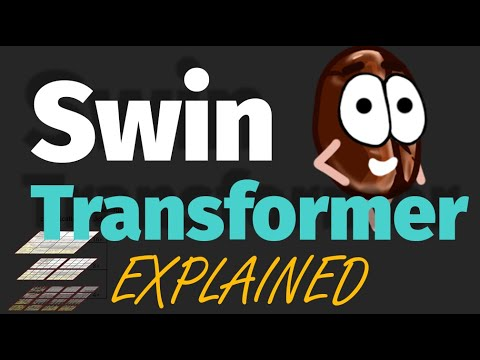

In [89]:
youtube_video = "https://www.youtube.com/watch?v=SndHALawoag"
video_id = youtube_video.split("=")[1]
from IPython.display import YouTubeVideo
YouTubeVideo(video_id)


In [94]:
pipeline('https://www.youtube.com/watch?v=qAwZdMIum0E',model_aug, tokenizer)

Time elapsed for get_subtitles: 50.309062004089355
Time elapsed for processing subtitles: 14.020203828811646
Time elapsed for summarization: 160.56814074516296
Time elapsed for post processing: 0.000152587890625
• Để chuẩn bị cho bài kiểm tra tiếng anh paper one hãy chuẩn bị trước bằng cách đọc kỹ các câu hỏi và giải thích từ vựng rõ ràng.
• Để tóm tắt câu hỏi sinh viên cần viết ngắn gọn và chính xác sử dụng dấu hiệu diễn ngôn phù hợp và bắt đầu với câu hỏi thứ nhất và thứ hai.
• Bắt đầu với câu hỏi thứ nhất và thứ hai với câu hỏi thứ nhất và câu hỏi thứ hai với câu hỏi thứ nhất và câu hỏi thứ hai với câu hỏi thứ nhất và câu hỏi thứ hai với câu hỏi thứ nhất và câu hỏi thứ hai với câu hỏi thứ nhất và câu hỏi thứ hai.
• Bắt đầu với câu hỏi thứ nhất và câu hỏi thứ hai với câu hỏi thứ nhất và câu hỏi thứ hai với câu hỏi thứ hai và cuối.
• Bắt đầu với câu hỏi thứ nhất và thứ hai với câu hỏi thứ nhất và câu hỏi thứ hai với câu hỏi thứ nhất và câu hỏi thứ hai với câu hỏi thứ nhất và câu hỏi t

'Để chuẩn bị cho bài kiểm tra tiếng anh paper one hãy chuẩn bị trước bằng cách đọc kỹ các câu hỏi và giải thích từ vựng rõ ràng. Để chuẩn bị cho bài kiểm tra tiếng anh paper one hãy chuẩn bị trước bằng cách đọc kỹ các câu hỏi và giải thích từ vựng rõ ràng. Để chuẩn bị cho bài kiểm tra tiếng anh paper one hãy chuẩn bị trước bằng cách đọc kỹ các câu hỏi và giải thích từ vựng rõ ràng. Để tóm tắt câu hỏi sinh viên cần viết ngắn gọn và chính xác sử dụng dấu hiệu diễn ngôn phù hợp và bắt đầu với câu hỏi thứ nhất và thứ hai. Bắt đầu với câu hỏi thứ nhất và thứ hai với câu hỏi thứ nhất và câu hỏi thứ hai với câu hỏi thứ nhất và câu hỏi thứ hai với câu hỏi thứ nhất và câu hỏi thứ hai với câu hỏi thứ nhất và câu hỏi thứ hai với câu hỏi thứ nhất và câu hỏi thứ hai. Bắt đầu với câu hỏi thứ nhất và câu hỏi thứ hai với câu hỏi thứ nhất và câu hỏi thứ hai với câu hỏi thứ hai và cuối. Bắt đầu với câu hỏi thứ nhất và thứ hai với câu hỏi thứ nhất và câu hỏi thứ hai với câu hỏi thứ nhất và câu hỏi thứ ha